In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import cosima_cookbook as cc
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### 1000 m isobath shelf mask

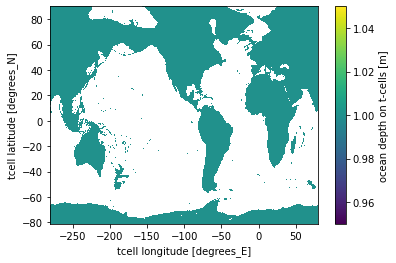

In [2]:
base_spin = '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_IPOCtrl/output976/'
vars = ['ht', 'hu']
for f in range(2): # loop through the t- and u-grid
    field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc')[vars[f]]
    above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
    above1000 = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000
    if f == 0: above1000_tcells = above1000
    if f == 1: above1000_ucells = above1000
above1000_tcells.plot()
b = field.fillna(0)

In [3]:
%%time
db = 'local_cc_scratch_2sigma_new_exe.db'; session = cc.database.create_session(db)
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt', '01deg_jra55_ryf_IPO2sNeg', 
              '01deg_jra55v13_ryf9091', '01deg_jra55v13_ryf9091_easterlies_up10', '01deg_jra55v13_ryf9091_easterlies_down10',
              '01deg_jra55v13_ryf_AKM_IPO2sNeg']
for e in [5]:
    print(exp[e])
    age_global = cc.querying.getvar(expt=exp[e], variable='age_global', session=session, frequency='1 monthly',
                                 attrs={'cell_methods': 'time: mean'},
                                 start_time='2153-01-01 00:00:00', 
                                 end_time='2154-11-31 00:00:00',
                                 chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})
    if e == 5: age_global_clim     = (age_global).mean(dim='time').compute()
bottom_mask = age_global_clim.where(~np.isfinite(age_global_clim.shift({'st_ocean': -1})))
bottom_mask = ~np.isnan(bottom_mask)
# Wall time: 1min 11s

01deg_jra55v13_ryf9091
CPU times: user 17.6 s, sys: 10.3 s, total: 27.9 s
Wall time: 1min 1s


### Loading in temperature and salinity values

In [4]:
%%time
db = 'local_cc_scratch_2sigma_new_exe.db'; session = cc.database.create_session(db)
# ------------------------------------------------------------------------------------ #
time        = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat     = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lat2    = [   0,   53]  # 89.57°S - 60.37°S                                        #
sel_lon     = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                              #
depth       = [  0,   75]   # [23] = 100 m to 1000 m                                   #
Weddell_lat = [   0,  239]  # 79°S to 71°S, the western Weddell Sea                    #
Weddell_lon = [2169, 2500]  # 63°W to 30°W or -63°E to -33°E                           #
Ross_lat    = [   0,  239] # 79°S to 71°S, the western Ross Sea                        #
Ross_lon    = [ 819,  1150] # -198°E to -165°E or 198°W to 165°W                       #
region      = ['Weddell Sea', 'Ross Sea']                                              #
# ------------------------------------------------------------------------------------ #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg', 
              '01deg_jra55v13_ryf9091_easterlies_up10', '01deg_jra55v13_ryf9091_easterlies_down10',
             '01deg_jra55v13_ryf_AKM_IPOCtrl', '01deg_jra55v13_ryf_AKM_IPO2sNeg']

exp_title = ['Control run', 'IPO$^{+}$', 'IPO$^{-}$', 'Interannual IPO run', 'IPO$^{-2\sigma}$', 'Wind$^{+10\%}$', 'Wind$^{-10\%}$', 'new .exe IPOCtrl', 'new .exe IPO$^{-2\sigma}$']
var  = ['temp', 'salt']
unit_name = ['Temperature', 'Salinity']
chunk_x = ['xt_ocean', 'xt_ocean'] # over which dimensions to chunk
chunk_y = ['yt_ocean', 'yt_ocean']
unit = ['(N m$^{-2}$)', '(°C)', '(psu)']
farbschema = [cm.cm.speed, 'RdBu_r', cm.cm.haline]
experiment_input = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields',
                   'winds_up10', 'winds_down10', '', '']

# plot a quick figure
for e in [1,2,4,5,6]: # loop through the four different experiments
    for v in range(2): # loop through the variables (v-wind, u-wind and salt; twice for both regions)
        print(var[v], exp[e])
        
        data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                  chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, 
                                  decode_times=False)[-36:,:,sel_lat[0]:sel_lat[1],:].mean('time')

        if e in [1,2,3,4]:
            data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', 
                                           attrs={'cell_methods': 'time: mean'}, chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, 
                                           decode_times=False)[-36:,:,sel_lat[0]:sel_lat[1],:].mean('time')
        if e in [5,6]:
            data_clim = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable=var[v], session=session, frequency='1 monthly', 
                                           attrs={'cell_methods': 'time: mean'}, 
                                           chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, 
                                           decode_times=False)[-36:,:,sel_lat[0]:sel_lat[1],:].mean('time')
        data_anom = (data-data_clim).where(bottom_mask).sum(dim='st_ocean').compute().load()  

        if e == 1 and v == 0: bottom_temp_anom_IPOPos = data_anom.load()
        if e == 1 and v == 1: bottom_salt_anom_IPOPos = data_anom.load()
        if e == 2 and v == 0: bottom_temp_anom_IPONeg = data_anom.load()
        if e == 2 and v == 1: bottom_salt_anom_IPONeg = data_anom.load()

        if e == 4 and v == 0: bottom_temp_anom_IPO2sNeg = data_anom.load()
        if e == 4 and v == 1: bottom_salt_anom_IPO2sNeg = data_anom.load()
        
        if e == 5 and v == 0: bottom_temp_anom_easterlies_up10 = data_anom.load()
        if e == 5 and v == 1: bottom_salt_anom_easterlies_up10 = data_anom.load()
        if e == 6 and v == 0: bottom_temp_anom_easterlies_down10 = data_anom.load()
        if e == 6 and v == 1: bottom_salt_anom_easterlies_down10 = data_anom.load()
# Wall time: 3 min 58 s for all five simulations (IPOPos, IPONeg, IPO2sNeg, up10, down10)
# Wall time: 8min 37s to .load() in all files

temp 01deg_jra55_ryf_IPOPos


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23050210551616 and this is thread id 23047233283840.
Exception closing connection <sqlite3.Connection object at 0x14f5ab918d50>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

salt 01deg_jra55_ryf_IPOPos
temp 01deg_jra55_ryf_IPONeg
salt 01deg_jra55_ryf_IPONeg
temp 01deg_jra55_ryf_IPO2sNeg
salt 01deg_jra55_ryf_IPO2sNeg
temp 01deg_jra55v13_ryf9091_easterlies_up10
salt 01deg_jra55v13_ryf9091_easterlies_up10
temp 01deg_jra55v13_ryf9091_easterlies_down10
salt 01deg_jra55v13_ryf9091_easterlies_down10
CPU times: user 1min 8s, sys: 16 s, total: 1min 24s
Wall time: 4min 24s


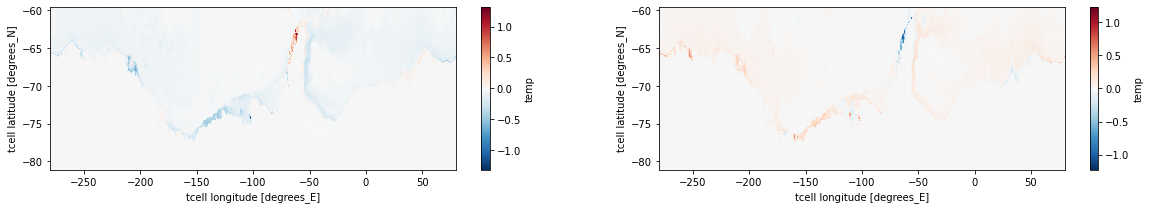

In [5]:
plt.figure(figsize=(20,3))
plt.subplot(1,2,1); bottom_temp_anom_easterlies_up10.plot()
plt.subplot(1,2,2); bottom_temp_anom_easterlies_down10.plot()

### Plotting routine

In [6]:
%%time
import matplotlib.path as mpath
def fancy_plot2(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 14.5 µs


Figure for IPOPos & IPONeg
Figure for IPO2sNeg & Winds-10%
Figure for Winds+10% & Winds-10%
CPU times: user 7min 51s, sys: 1min 23s, total: 9min 14s
Wall time: 8min 3s


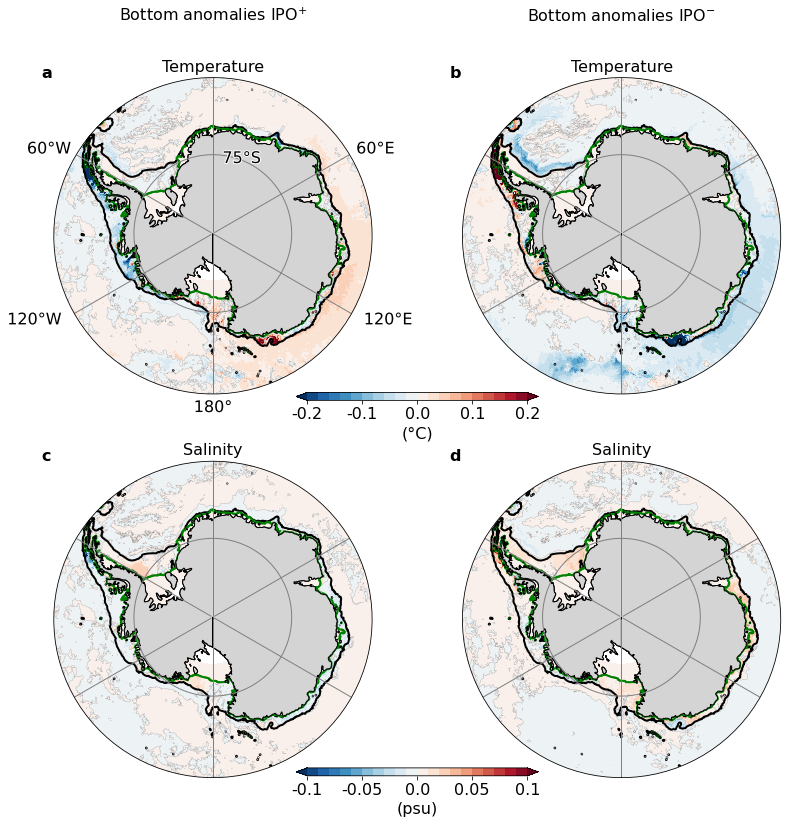

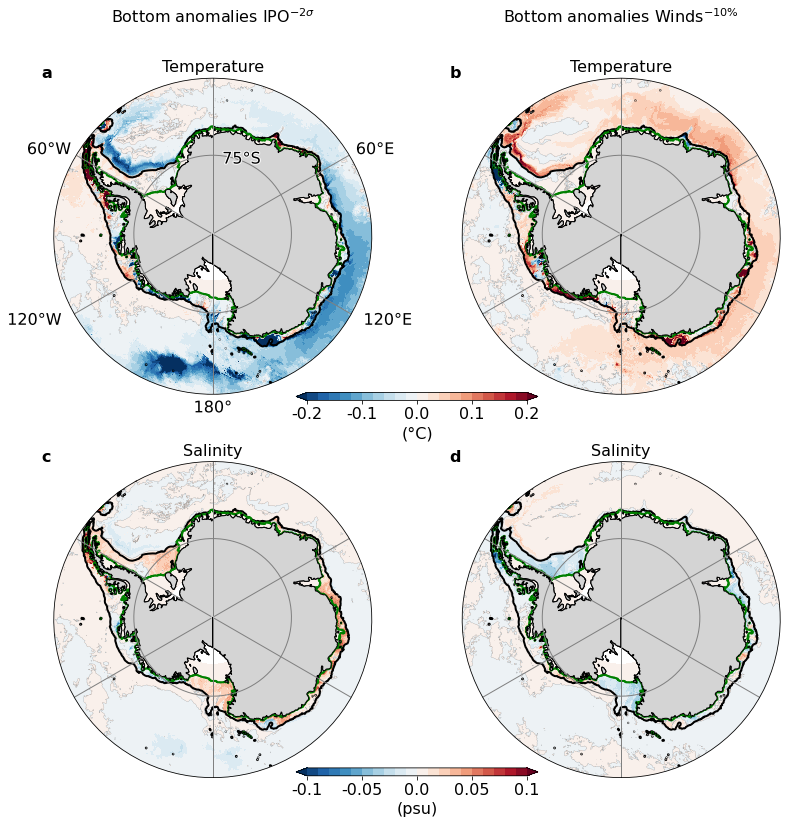

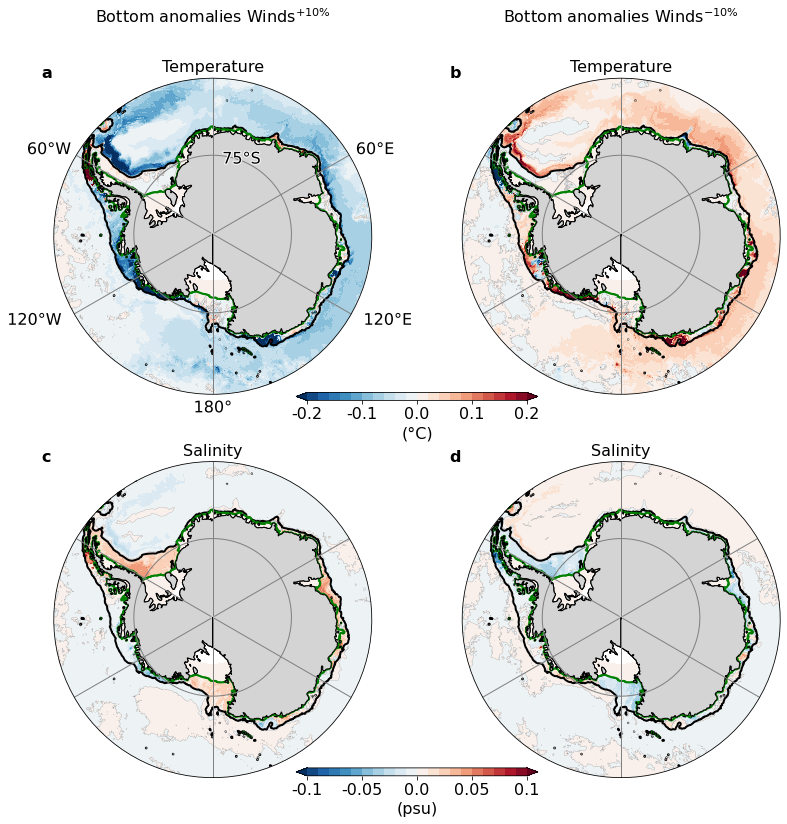

In [7]:
%%time
for r in [0,1,2]:#range(2):
    if r == 0: print('Figure for IPOPos & IPONeg')
    if r == 1: print('Figure for IPO2sNeg & Winds-10%')
    if r == 2: print('Figure for Winds+10% & Winds-10%')

    # Here the figure starts properly
    fig = plt.figure(figsize=(14,11),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2,2, width_ratios = [1,1], height_ratios = [1,1]) 
    proj = ccrs.PlateCarree()
    ticks = np.linspace(-.03,.03,21)
    
    for f in range(4): # loop through each subplot
        if f == 0:  panel = gs[0,0]; farben = 'RdBu_r'; ticks = np.linspace(-.2,.2,21); titel = 'Temperature'
        if f == 1:  panel = gs[0,1]; farben = 'RdBu_r'; ticks = np.linspace(-.2,.2,21); titel = 'Temperature'
        if f == 2:  panel = gs[1,0]; farben = 'RdBu_r'; ticks = np.linspace(-.1,.1,21); titel = '\nSalinity'
        if f == 3:  panel = gs[1,1]; farben = 'RdBu_r'; ticks = np.linspace(-.1,.1,21); titel = '\nSalinity'


        if f == 0 and r == 0: map = bottom_temp_anom_IPOPos; title_string = 'IPO$^{+}$'
        if f == 1 and r == 0: map = bottom_temp_anom_IPONeg; title_string = 'IPO$^{-}$'
        if f == 2 and r == 0: map = bottom_salt_anom_IPOPos
        if f == 3 and r == 0: map = bottom_salt_anom_IPONeg

        if f == 0 and r == 1: map = bottom_temp_anom_IPO2sNeg; title_string = 'IPO$^{-2\sigma}$'
        if f == 1 and r == 1: map = bottom_temp_anom_easterlies_down10; title_string = 'Winds$^{-10\%}$'
        if f == 2 and r == 1: map = bottom_salt_anom_IPO2sNeg
        if f == 3 and r == 1: map = bottom_salt_anom_easterlies_down10

        if f == 0 and r == 2: map = bottom_temp_anom_easterlies_up10; title_string = 'Winds$^{+10\%}$'
        if f == 1 and r == 2: map = bottom_temp_anom_easterlies_down10; title_string = 'Winds$^{-10\%}$'
        if f == 2 and r == 2: map = bottom_salt_anom_easterlies_up10
        if f == 3 and r == 2: map = bottom_salt_anom_easterlies_down10
            
        # panels with spatial maps ---------------------------------------------------------------------------------------------------------------- #
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.coastlines(resolution='50m')
        ax1.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap=farben, transform=proj)
        p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=proj)
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=proj) # 1000 m isobath
        # adding line where ACCESS-OM2-01 has land instead of ice shelves
        plt.contour(b.xu_ocean, b.yu_ocean, b, levels=[1], colors='g', linewidths=2, transform=proj) # green line outlining 'ice shelves' in ACCESS-OM2
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        if f == 0: plt.text(0,-50,'Bottom anomalies '+title_string, fontsize=16, ha='center', va='center', transform=ccrs.PlateCarree()) # x0, y0
        if f == 1: plt.text(0,-50,'Bottom anomalies '+title_string, fontsize=16, ha='center', va='center', transform=ccrs.PlateCarree()) # x0, y0
        plt.title(titel, fontsize=16)
        ax1.text(-.04,1, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        fancy_plot2(ax1)

        # add longitude/latitude labels for the very first top left plot
        if f == 0:
            xlab =    [  1.01,    1.05,     .5,   -.061,  -.015,     .59] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .73] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S']
            
            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
                
        # add colour bars
        if f == 1:
            cax = fig.add_axes([.38, .49, .24, .01]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
        if f == 3:
            cax = fig.add_axes([.38, .016, .24, .01])
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(psu)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
        # if f in [2,3]: ax1.text(-.05, 1.1, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        
    if r == 0: filename = 'IPOPos_and_IPONeg'
    if r == 1: filename = 'IPO2sNeg'
    if r == 2: filename = 'Winds_up_and_down'
    # --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
    plt.savefig(save + 'Bottom_temperature_and_salinity_anomalies_01deg_jra55_ryf_'+filename,                     #
                dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,       #
                transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                            #
    # --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 2min 24s for one figure, but it takes slightly longer to render it (about 3 mins)
# Wall time: 8min 4s for all figures

### Preparing the wind speed field

01deg_jra55_ryf_IPOPos
01deg_jra55_ryf_IPONeg
01deg_jra55_ryf_IPO2sNeg
01deg_jra55v13_ryf9091_easterlies_down10
01deg_jra55v13_ryf_AKM_IPOCtrl
CPU times: user 5.45 s, sys: 1.42 s, total: 6.87 s
Wall time: 43.5 s


<Figure size 1440x216 with 0 Axes>

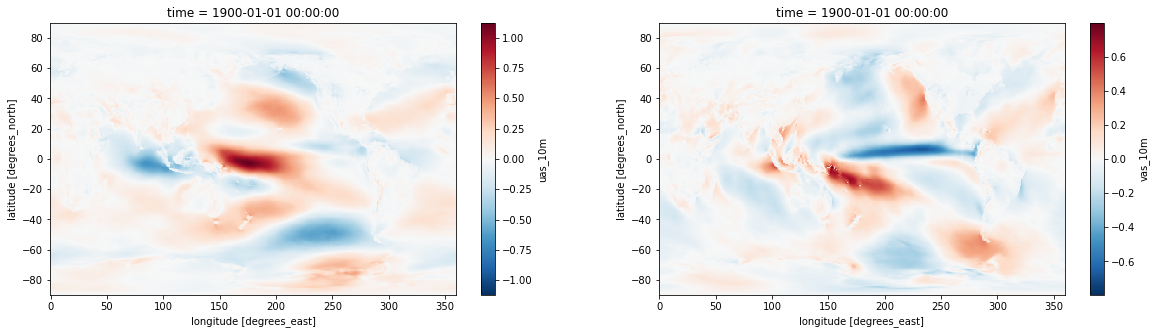

In [8]:
%%time
variablen = ['uas_10m', 'vas_10m']
plt.figure(figsize=(20,3))
for e in [1,2,4,6,7]: #[1,2,4]
    print(exp[e])
    uas_RYF          = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/'+'original_RYF.'+variablen[0]+'.1990_1991.nc')[variablen[0]]
    vas_RYF          = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/'+'original_RYF.'+variablen[1]+'.1990_1991.nc')[variablen[1]]
    uas_IPOPos       = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/positive_phase_fields/'+'RYF.'+variablen[0]+'.1990_1991.nc')[variablen[0]]
    vas_IPOPos       = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/positive_phase_fields/'+'RYF.'+variablen[1]+'.1990_1991.nc')[variablen[1]]

    
    
    if e == 1:
        uas_IPOPos_anom = (uas_IPOPos-uas_RYF)[0,:,:].load()
        vas_IPOPos_anom = (vas_IPOPos-vas_RYF)[0,:,:].load()
        plt.figure(figsize=(20,5)); plt.subplot(1,2,1); uas_IPOPos_anom.plot(); plt.subplot(1,2,2); vas_IPOPos_anom.plot()
    if e == 2:
        uas_IPONeg_anom = -(uas_IPOPos-uas_RYF)[0,:,:].load()
        vas_IPONeg_anom = -(vas_IPOPos-vas_RYF)[0,:,:].load()
    if e in [4,8]:
        uas_IPO2sNeg_anom = -2*(uas_IPOPos-uas_RYF)[0,:,:].load()
        vas_IPO2sNeg_anom = -2*(vas_IPOPos-vas_RYF)[0,:,:].load()  
    if e == 6:
        uas_up10_anom = .1*(uas_RYF)[0,:,:].load()
        vas_up10_anom = .1*(vas_RYF)[0,:,:].load() 
    if e == 7:
        uas_down10_anom = -.1*(uas_RYF)[0,:,:].load()
        vas_down10_anom = -.1*(vas_RYF)[0,:,:].load() 
# Wall time: 60 s

### Zooming into the Weddell and Ross Seas

In [ ]:
%%time
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28]}
base        = '/g/data/e14/mv7494/IPOAnt_input/'
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt', '01deg_jra55_ryf_IPO2sNeg', 
              '01deg_jra55v13_ryf9091', '01deg_jra55v13_ryf9091_easterlies_up10', '01deg_jra55v13_ryf9091_easterlies_down10',
              '01deg_jra55v13_ryf_AKM_IPO2sNeg', '01deg_jra55v13_ryf_AKM_IPO2sNeg_anoms']
in_location = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields', 
               '', 'AKM_2sigma_negative_phase_fields']
suffix      = ['Control run', 'IPO$^{+}$', 
               'IPO$^{-}$', 'Interannual run', 'IPO$^{2-}$',
               'Control run new', 'Winds$^{+10\%}$', 'Winds$^{-10\%}$', 
               'IPO$^{2-}$ new', 'IPO$^{2-}$ new anomalies']

var  = [   'temperature',    'salinity']
var2 = ['temp', 'salt']   
var3 = [    'temp',     'salt'] 


fig = plt.figure(figsize=(16,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, height_ratios = [.47,1,1]); proj = ccrs.PlateCarree()

for f in range(9):
    if f == 0:
    # first top panel with ASL and shelf region --------------------------------------------------------------------------------------------------------------------------------------- #
        pressure = (xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/spatial_patterns/'+'sp_IPO_time_series_1958-2022.nc').psl[0:60,:]*-1).load().drop('height')
        
        ax = plt.subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=50))
        fieldAnt = field[:500,:] * above1000_ucells # only select Antarctic margin
        leichtgrau = [.83, .83, .83]
        p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,1000,21), cmap='#D3D3D3', add_colorbar = False, transform=ccrs.PlateCarree()) # 1000 m isobath
        p111 = field[:500,:].plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
       
        p2727 = (pressure/100).plot.contour(levels = np.linspace(-2,0,10), linewidths=.75, colors = 'grey', transform=ccrs.PlateCarree()) # sea level pressure contours
        peak_anom_coords = pressure.where(pressure == pressure.min(), drop=True).lat # [lon, lat] of minimum pressure is [246.9375, -62.059151] -> I use these to plot the big letter 'L'
        txt = plt.text(246.9375, -62.059151, 'L', c='k', fontsize=27, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
        ax.axis('off') # turn off axes

        # additional burgundy regions to areas for the Ross and Weddell Seas       
        line_kwargs = dict(color=rotblau[3], linewidth=2, zorder=2, transform=ccrs.PlateCarree()) # shared line style
        
        # reusable rectangle plotting function
        def plot_rectangle(x_min, x_max, y_min, y_max, **kwargs):
            plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], **kwargs)        
        # plot both rectangles & the labels + white background behind the text to make it better visible
        plot_rectangle( -70,  -20, -79, -71, **line_kwargs); ax.text(-205, -79,    'Ross Sea', ha = 'right', size=16, color=rotblau[3], 
                                                                     transform=ccrs.PlateCarree()).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        plot_rectangle(-200, -140, -79, -71, **line_kwargs); ax.text( -15, -79, 'Weddell Sea', ha =  'left', size=16, color=rotblau[3], 
                                                                     transform=ccrs.PlateCarree()).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- #

    if f in [3,4,7,8]: minlon, maxlon, minlat, maxlat = [140, 210, -79, -59] # Ross Sea extent
    if f in [1,2,5,6]: minlon, maxlon, minlat, maxlat = [-70, -20, -79, -59] # Weddell Sea extent

    if f in [1, 2]:      ax = plt.subplot(gs[1,f-1], projection=ccrs.Mercator(central_longitude=180, min_latitude=-85, max_latitude=-50, latitude_true_scale=-70))
    if f in [5, 6]:      ax = plt.subplot(gs[2, f-5], projection=ccrs.Mercator(central_longitude=180, min_latitude=-85, max_latitude=-50, latitude_true_scale=-70))

    if f in [3, 4]:      ax = plt.subplot(gs[1,f-1], projection=ccrs.Mercator(central_longitude=180, min_latitude=-85, max_latitude=-50, latitude_true_scale=-70))
    if f in [7, 8]:      ax = plt.subplot(gs[2, f-5], projection=ccrs.Mercator(central_longitude=180, min_latitude=-85, max_latitude=-50, latitude_true_scale=-70))

    if f in [1,2,3,4]: limiten = [-.2,.2]; unit = '(°C)'
    if f in [5,6,7,8]: limiten = [-.1,.1]; unit = '(psu)'
        
    # panels for the Ross Sea on the right
    if f == 1: data  = bottom_temp_anom_easterlies_down10;   uas = uas_down10_anom; vas = vas_down10_anom;          panel_letter = [0, 1]; print('Ross temp')
    if f == 2: data  = bottom_temp_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [0, 1]; print('Ross temp')
    if f == 3: data  = bottom_temp_anom_easterlies_down10;   uas = uas_down10_anom; vas = vas_down10_anom;          panel_letter = [4, 5]; print('Weddell temp')
    if f == 4: data  = bottom_temp_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [4, 5]; print('Weddell temp')

    # panels for the Weddell Sea on the left
    if f == 5: data  = bottom_salt_anom_easterlies_down10;   uas = uas_down10_anom; vas = vas_down10_anom;          panel_letter = [0, 1]; print('Ross salt')
    if f == 6: data  = bottom_salt_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [0, 1]; print('Ross salt')
    if f == 7: data  = bottom_salt_anom_easterlies_down10;   uas = uas_down10_anom; vas = vas_down10_anom;          panel_letter = [4, 5]; print('Weddell salt')
    if f == 8: data  = bottom_salt_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [4, 5]; print('Weddell salt')

    ax.text(-.1, 1.1,string.ascii_lowercase[f], transform=ax.transAxes, size=16, weight='bold') # c, d, e                

    if f != 0: 
        ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
        gl = ax.gridlines(draw_labels=False, crs=proj, alpha=0)
        # hide unnecessary tick labels
        if f in [1, 5]: gl.left_labels = True
        else: gl.left_labels = False
        if f in [1, 2, 3, 4]: gl.bottom_labels = False
        gl.ylabel_style = {'size': 16}
        # gl.bottom_labels = True
    
        if f in [3,4,7,8]:
            gl.xlocator = mticker.FixedLocator(np.arange(140, 200, 10))
            ax.set_xticks(np.arange(140, 200, 20), crs=proj); plt.xticks(fontsize=16); 
            ax.set_yticklabels([]); ax.set(ylabel=None) 
                
        if f in [1,2,5,6]:
            gl.xlocator = mticker.FixedLocator(np.arange(-70, -10, 10))
            ax.set_xticks(np.arange(-60, -20, 20), crs=proj); plt.xticks(fontsize=16); 
            # ax.set_yticks(np.arange(-62, -66, -70, -74, -78), crs=proj); plt.yticks(fontsize=16);         
            
        plt.yticks(fontsize=16)        
        ax.xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
        ax.tick_params(length=0)
        gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
    
        ax.coastlines(resolution='50m')

        # plotting the data here ------------------------------------------------------------------------------------------------------------------------------------ #
        plt.contour(b.xu_ocean, b.yu_ocean, b, levels=[1], colors='g', linewidths=2, transform=proj) # green line outlining 'ice shelves' in ACCESS-OM2
        plt.contour(field.xu_ocean, field.yu_ocean, field, levels=[1000], colors='k', linewidths=1, transform=proj)   

        if f in [1,2,3,4]: p1   = data.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, extend='max', cmap = 'RdBu_r', transform=ccrs.PlateCarree())
        if f in [5,6,7,8]: p1   = data.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, extend='max', cmap = 'RdBu_r', transform=ccrs.PlateCarree())
        p11  = data.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())

        # here adding the main data to the figures
        if f in [1,2,3,4]: # add the wind speed arrows, only plotting every 30th data point.
            X = uas.longitude; Y = vas.latitude; U = uas; V = vas
            # --------------------------------------------------------------------------------------------------------------------------- #
            abstand = 3 # plot every n-th wind arrow
            skala = 5
            Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
                           scale=skala, minshaft = 2, scale_units='height', transform=proj, width=.005, linewidths=.5, edgecolor=('w'),
                          zorder=1) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # --------------------------------------------------------------------------------------------------------------------------- #
        if f == 1: # add reference key,  x0,   y0 of quiver key
            qk = plt.quiverkey(Q,        .6,    1.05, .25, r'0.25 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel
        
        # titles
        if f in [1, 3]: plt.title('Winds$^{-10\%}$', fontsize=20, y=1.2, fontweight='bold') # bold column titles
        if f in [2, 4]: plt.title('IPO$^{-2\sigma}$', fontsize=20, y=1.2, fontweight='bold')
            
        if f in [4, 8]:
            pos = ax.get_position()
            cax = plt.axes([pos.xmax+.05, pos.ymin, .013, 1*(pos.ymax-pos.ymin)])
            cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='both')
            cb.ax.set_ylabel(unit, fontsize=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            #cb.add_lines(p1) # add contours to colour bar   

        # --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
        plt.savefig(save + 'Bottom_anomalies_01deg_jra55_ryf_Winds_down_IPO2sNeg_big_zoom',             #
                    dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,       #
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                            #
        # --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 32min 6s

Ross temp
Ross temp
Weddell temp
Weddell temp


In [ ]:
### Check zorder of the wind stress arrows!

In [ ]:
for v in range(2): # loop through temperature and salinity
    print(var[v])
    if v == 0: limiten = [-.2,.2]; unit = '(°C)'
    if v == 1: limiten = [-.1,.1]; unit = '(psu)'
    for e in [6]:#,7,4]:
        if v == 0 and e == 6: data  = bottom_temp_anom_easterlies_up10;   uas = uas_up10_anom; vas = vas_up10_anom;          panel_letter = [0, 1]
        if v == 1 and e == 6: data  = bottom_salt_anom_easterlies_up10;   uas = uas_up10_anom; vas = vas_up10_anom;          panel_letter = [4, 5]
        if v == 0 and e == 7: data  = bottom_temp_anom_easterlies_down10; uas = uas_down10_anom; vas = vas_down10_anom;      panel_letter = [2, 3]
        if v == 1 and e == 7: data  = bottom_salt_anom_easterlies_down10; uas = uas_down10_anom; vas = vas_down10_anom;      panel_letter = [6, 7]

        if v == 0 and e == 4: data  = bottom_temp_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [0, 1]
        if v == 1 and e == 4: data  = bottom_salt_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [4, 5]
    

    
        print(exp[e])        
        for a, area_text in enumerate(DSW_region['name']):
    #        if a in [1, 2]: continue
            if a == 0: # Weddell Sea
                minlon, maxlon, minlat, maxlat = [-70, -20, -79, -59]
                letter = string.ascii_lowercase[0] + ') '
            elif a == 3: # Ross Sea
                minlon, maxlon, minlat, maxlat = [140, 210, -79, -59]
                letter = string.ascii_lowercase[1] + ') '
            
            if a == 0:
                ax = plt.subplot(2, 6, (1, 2), projection=ccrs.Mercator(
                    min_latitude=-85, max_latitude=-50,
                    latitude_true_scale=-70))
                ax.text(-.1, 1.1,string.ascii_lowercase[panel_letter[0]], transform=ax.transAxes, size=16, weight='bold') # c, d, e
            elif a == 3:
                ax = plt.subplot(2, 6, (3, 5), projection=ccrs.Mercator(
                    central_longitude=180, min_latitude=-85, max_latitude=-50,
                    latitude_true_scale=-70))
                ax.text(-.1, 1.1,string.ascii_lowercase[panel_letter[1]], transform=ax.transAxes, size=16, weight='bold') # c, d, e                
        
            ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
            gl = ax.gridlines(draw_labels=False, crs=proj, alpha=1)
            gl.left_labels = True
            gl.ylabel_style = {'size': 16}
            # gl.bottom_labels = True
            if area_text == 'Weddell':
                gl.xlocator = mticker.FixedLocator(np.arange(-70, -10, 10))
                ax.set_xticks(np.arange(-60, -20, 20), crs=proj); plt.xticks(fontsize=16); 
                # ax.set_yticks(np.arange(-62, -66, -70, -74, -78), crs=proj); plt.yticks(fontsize=16);         
                
                plt.yticks(fontsize=16)
            elif area_text == 'Ross':
                gl.xlocator = mticker.FixedLocator(np.arange(140, 200, 10))
                ax.set_xticks(np.arange(140, 200, 20), crs=proj); plt.xticks(fontsize=16); 
                ax.set_yticklabels([]); ax.set(ylabel=None) 
            ax.xaxis.set_major_formatter(LongitudeFormatter(
                dateline_direction_label=True))
            ax.tick_params(length=0)
            gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
        
            ax.coastlines(resolution='50m')
    
            # plotting the data here ------------------------------------------------------------------------------------------------------------------------------------ #
#            plt.contour(b.xu_ocean, b.yu_ocean, b, levels=[1], colors='g', linewidths=2, transform=proj) # green line outlining 'ice shelves' in ACCESS-OM2
#            plt.contour(field.xu_ocean, field.yu_ocean, field, levels=[1000], colors='k', linewidths=1, transform=proj)   
            
            # plotting here
            #karte = (vi_con_IPOPOs_anom.mean('st_ocean')*mask_DSW[a,:,:]); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
            #karte = (above1000_tcells); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
#            p1   = data.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, extend='max', cmap = 'RdBu_r', transform=ccrs.PlateCarree())
#            p11  = data.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
    
            # ----------------------------------------------------------------------------------------------------------------------------------------------------------- #

            # Add the wind speed arrows, only plotting every 30th data point.
#            X = uas.longitude; Y = vas.latitude; U = uas; V = vas
            # --------------------------------------------------------------------------------------------------------------------------- #
            abstand = 3 # plot every n-th wind arrow
            skala = 5
#            Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
#                           scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.5, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # --------------------------------------------------------------------------------------------------------------------------- #
#            if a == 0: # add reference key,  x0,   y0 of quiver key
#                qk = plt.quiverkey(Q,        0,    1.2, .25, r'0.25 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel

            ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
            if a == 0: plt.title('Weddell Sea', fontsize=16)
            if a == 3: plt.title('Ross Sea', fontsize=16)
        
            ax.set_yticklabels([]); ax.set(ylabel=None) 
            if a == 3:    
                pos = ax.get_position()
                cax = plt.axes([pos.xmax+.085, pos.ymin+0.04,
                                0.013, .8*(pos.ymax-pos.ymin)])
                cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='both')
                cb.ax.set_ylabel(unit, fontsize=16)
                cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
                cb.locator = tick_locator;cb.update_ticks()
                cb.add_lines(p11) # add contours to colour bar   
    
        
    #        if a == 3: ax.text(-.1, 1.15,string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # c, d, e
        
        plt.suptitle(var[v]+' anomalies ' + suffix[e], fontsize=16)
        plt.suptitle(suffix[e], y=1.05, fontsize=20, fontweight='bold') # x0, y0
        

# BACKUP, DO NOT DELETE

temperature
01deg_jra55v13_ryf9091_easterlies_up10
temp_Winds_up
----------------------------------------
salinity
01deg_jra55v13_ryf9091_easterlies_up10
salt_Winds_up
----------------------------------------
CPU times: user 1min 12s, sys: 7.19 s, total: 1min 20s
Wall time: 1min 11s


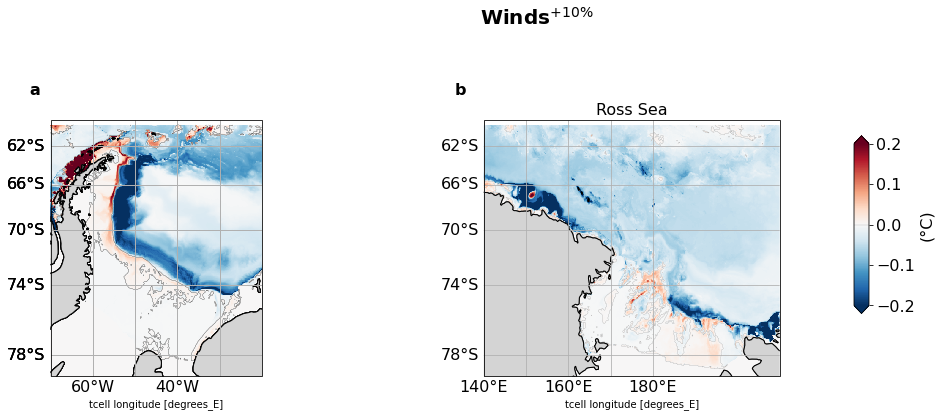

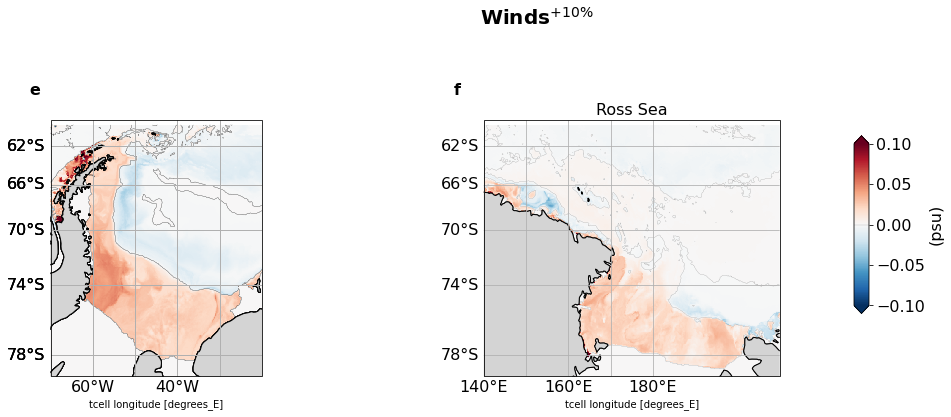

In [82]:
%%time
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28]}
base        = '/g/data/e14/mv7494/IPOAnt_input/'
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt', '01deg_jra55_ryf_IPO2sNeg', 
              '01deg_jra55v13_ryf9091', '01deg_jra55v13_ryf9091_easterlies_up10', '01deg_jra55v13_ryf9091_easterlies_down10',
              '01deg_jra55v13_ryf_AKM_IPO2sNeg', '01deg_jra55v13_ryf_AKM_IPO2sNeg_anoms']
in_location = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields', 
               '', 'AKM_2sigma_negative_phase_fields']
suffix      = ['Control run', 'IPO$^{+}$', 
               'IPO$^{-}$', 'Interannual run', 'IPO$^{2-}$',
               'Control run new', 'Winds$^{+10\%}$', 'Winds$^{-10\%}$', 
               'IPO$^{2-}$ new', 'IPO$^{2-}$ new anomalies']

var  = [   'temperature',    'salinity']
var2 = ['temp', 'salt']   
var3 = [    'temp',     'salt'] 

for v in range(2): # loop through temperature and salinity
    print(var[v])
    if v == 0: limiten = [-.2,.2]; unit = '(°C)'
    if v == 1: limiten = [-.1,.1]; unit = '(psu)'
    for e in [6]:#,7,4]:
        if v == 0 and e == 6: data  = bottom_temp_anom_easterlies_up10;   uas = uas_up10_anom; vas = vas_up10_anom;          panel_letter = [0, 1]
        if v == 1 and e == 6: data  = bottom_salt_anom_easterlies_up10;   uas = uas_up10_anom; vas = vas_up10_anom;          panel_letter = [4, 5]
        if v == 0 and e == 7: data  = bottom_temp_anom_easterlies_down10; uas = uas_down10_anom; vas = vas_down10_anom;      panel_letter = [2, 3]
        if v == 1 and e == 7: data  = bottom_salt_anom_easterlies_down10; uas = uas_down10_anom; vas = vas_down10_anom;      panel_letter = [6, 7]

        if v == 0 and e == 4: data  = bottom_temp_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [0, 1]
        if v == 1 and e == 4: data  = bottom_salt_anom_IPO2sNeg;          uas = uas_IPO2sNeg_anom; vas = vas_IPO2sNeg_anom;  panel_letter = [4, 5]
    
        fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
        gs = gridspec.GridSpec(1,2); proj = ccrs.PlateCarree()
    
        print(exp[e])        

        for a, area_text in enumerate(DSW_region['name']):
    #        if a in [1, 2]: continue
            if a == 0: # Weddell Sea
                minlon, maxlon, minlat, maxlat = [-70, -20, -79, -59]
                letter = string.ascii_lowercase[0] + ') '
            elif a == 3: # Ross Sea
                minlon, maxlon, minlat, maxlat = [140, 210, -79, -59]
                letter = string.ascii_lowercase[1] + ') '
            
            if a == 0:
                ax = plt.subplot(2, 6, (1, 2), projection=ccrs.Mercator(
                    min_latitude=-85, max_latitude=-50,
                    latitude_true_scale=-70))
                ax.text(-.1, 1.1,string.ascii_lowercase[panel_letter[0]], transform=ax.transAxes, size=16, weight='bold') # c, d, e
            elif a == 3:
                ax = plt.subplot(2, 6, (3, 5), projection=ccrs.Mercator(
                    central_longitude=180, min_latitude=-85, max_latitude=-50,
                    latitude_true_scale=-70))
                ax.text(-.1, 1.1,string.ascii_lowercase[panel_letter[1]], transform=ax.transAxes, size=16, weight='bold') # c, d, e                
        
            ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
            gl = ax.gridlines(draw_labels=False, crs=proj, alpha=1)
            gl.left_labels = True
            gl.ylabel_style = {'size': 16}
            # gl.bottom_labels = True
            if area_text == 'Weddell':
                gl.xlocator = mticker.FixedLocator(np.arange(-70, -10, 10))
                ax.set_xticks(np.arange(-60, -20, 20), crs=proj); plt.xticks(fontsize=16); 
                # ax.set_yticks(np.arange(-62, -66, -70, -74, -78), crs=proj); plt.yticks(fontsize=16);         
                
                plt.yticks(fontsize=16)
            elif area_text == 'Ross':
                gl.xlocator = mticker.FixedLocator(np.arange(140, 200, 10))
                ax.set_xticks(np.arange(140, 200, 20), crs=proj); plt.xticks(fontsize=16); 
                ax.set_yticklabels([]); ax.set(ylabel=None) 
            ax.xaxis.set_major_formatter(LongitudeFormatter(
                dateline_direction_label=True))
            ax.tick_params(length=0)
            gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
        
            ax.coastlines(resolution='50m')
    
            # plotting the data here ------------------------------------------------------------------------------------------------------------------------------------ #
#            plt.contour(b.xu_ocean, b.yu_ocean, b, levels=[1], colors='g', linewidths=2, transform=proj) # green line outlining 'ice shelves' in ACCESS-OM2
#            plt.contour(field.xu_ocean, field.yu_ocean, field, levels=[1000], colors='k', linewidths=1, transform=proj)   
            
            # plotting here
            #karte = (vi_con_IPOPOs_anom.mean('st_ocean')*mask_DSW[a,:,:]); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
            #karte = (above1000_tcells); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
            p1   = data.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, extend='max', cmap = 'RdBu_r', transform=ccrs.PlateCarree())
            p11  = data.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
    
            # ----------------------------------------------------------------------------------------------------------------------------------------------------------- #

            # Add the wind speed arrows, only plotting every 30th data point.
#            X = uas.longitude; Y = vas.latitude; U = uas; V = vas
            # --------------------------------------------------------------------------------------------------------------------------- #
            abstand = 3 # plot every n-th wind arrow
            skala = 5
#            Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
#                           scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.5, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # --------------------------------------------------------------------------------------------------------------------------- #
#            if a == 0: # add reference key,  x0,   y0 of quiver key
#                qk = plt.quiverkey(Q,        0,    1.2, .25, r'0.25 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel

            ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
            if a == 0: plt.title('Weddell Sea', fontsize=16)
            if a == 3: plt.title('Ross Sea', fontsize=16)
        
            ax.set_yticklabels([]); ax.set(ylabel=None) 
            if a == 3:    
                pos = ax.get_position()
                cax = plt.axes([pos.xmax+.085, pos.ymin+0.04,
                                0.013, .8*(pos.ymax-pos.ymin)])
                cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='both')
                cb.ax.set_ylabel(unit, fontsize=16)
                cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
                cb.locator = tick_locator;cb.update_ticks()
                cb.add_lines(p11) # add contours to colour bar   
    
        
    #        if a == 3: ax.text(-.1, 1.15,string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # c, d, e
        
        plt.suptitle(var[v]+' anomalies ' + suffix[e], fontsize=16)
        plt.suptitle(suffix[e], y=1.05, fontsize=20, fontweight='bold') # x0, y0
        
        if v == 0 and e == 6: filename  = 'temp_Winds_up'
        if v == 1 and e == 6: filename  = 'salt_Winds_up'
        if v == 0 and e == 7: filename  = 'temp_Winds_down'
        if v == 1 and e == 7: filename  = 'salt_Winds_down'

        if v == 0 and e == 4: filename  = 'temp_IPO2sNeg'
        if v == 1 and e == 4: filename  = 'salt_IPO2sNeg'
        print(filename) 
        # --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
        plt.savefig(save + 'Bottom_anomalies_01deg_jra55_ryf_'+filename+'_zoom',             #
                    dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,       #
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                            #
        # --- end of script ----------------------------------------------------------------------------------------- # 
    print('----------------------------------------')
    # Wall time: 7min 20s for three simulations (Ctrl, AKM_2sNeg, AKM_2sNeg-Ctrl)
# Wall time: 31min 21s

### Combining IPO2sNeg and Winds-10% simulations to one big figure

In [15]:
area_text

'Ross'